In [26]:
import pandas as pd
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten,Conv2D,Conv1D,MaxPooling1D, Dropout
from keras.layers import concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D,BatchNormalization
from keras.models import Model, Sequential
from keras.layers import Convolution1D,GlobalMaxPooling1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.optimizers import Adam
from keras.utils import to_categorical
import numpy as np
import sys
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as ktf
from keras.datasets import imdb

In [27]:
#######################################################################
# Read in Data and tokenize , prepare training data and test data
#df = pd.read_csv("C:/Users/Harvey/Desktop/Yelp_data_set/restuarant_review_5_label_unbalanced.csv")
#df = pd.read_csv("/home/ec2-user/Data/restuarant_review_5_label_unbalanced.csv")



#df = pd.read_csv("C:/Users/Harvey/Desktop/Yelp_data_set/restuarant_review_balanced.csv"
#df = pd.read_csv("/home/ec2-user/Data/restuarant_review_5_label_unbalanced.csv")
#df = pd.read_csv("/usr4/cs542sp/zzjiang/Data/restuarant_review_5_label_unbalanced.csv")
#train= pd.read_csv("/Users/harvey/Desktop/Data/restuarant_balanced_2_train.csv",lineterminator='\n')
#test = pd.read_csv("/Users/harvey/Desktop/Data/restuarant_balanced_2_test.csv",lineterminator='\n')

train= pd.read_csv("/home/ec2-user/Data/restuarant_balanced_2_train.csv",lineterminator='\n')
test = pd.read_csv("/home/ec2-user/Data/restuarant_balanced_2_test.csv",lineterminator='\n')
reviews_train = train['Processed_Reviews\r']
reviews_test = test['Processed_Reviews\r']
print(train.shape)
print(test.shape)


(208160, 2)
(50000, 2)


In [8]:
maxlen = 100
max_features = 15000
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(reviews_train)
list_tokenized_train = tokenizer.texts_to_sequences(reviews_train)
x_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
y_train =train['stars']
#####################
# Test data
tokenizer.fit_on_texts(reviews_test)
list_tokenized_test = tokenizer.texts_to_sequences(reviews_test)
x_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
y_test = test['stars']
###################################################

In [28]:
##################################
# IMDB DATA SET FOR DEBUG 

max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 100
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(x_train.shape)
print(x_test.shape)

print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test  = pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)

imdb_dir = "/home/ec2-user/aclImdb"

train_dir = os.path.join(imdb_dir, "train")

labels = []
texts = []

for label_type in ["neg", "pos"]:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname [-4:] == ".txt":
            #f = open(os.path.join(dir_name, fname))
            # using code above gave: UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 194: character maps to <undefined>
            # added: encoding='utf-8'
            f = open(os.path.join(dir_name, fname), encoding='utf-8')
            texts.append(f.read())
            f.close()
            if label_type == "neg":
                labels.append(0)
            else:
                labels.append(1)

maxlen = 100 # cuts off review after 100 words
training_samples = 20000 # Trains on 200 samples
validation_samples = 5000 # Validates o 10000 samples
max_words = 10000 # Considers only the top 10000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index                   # Length: 88582
print("Found %s unique tokens." % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print("Shape of data tensor:", data.shape)
print("Shape of label tensor:", labels.shape)

indices = np.arange(data.shape[0]) # Splits data into training and validation set, but shuffles is, since samples are ordered: 
# all negatives first, then all positive
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples] # (200, 100)
y_train = labels[:training_samples] # shape (200,)
x_test = data[training_samples:training_samples+validation_samples] # shape (10000, 100)
y_test = labels[training_samples:training_samples+validation_samples] # shape (10000,)
# IMDB
###############################################################################################

Loading data...
(25000,)
(25000,)
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [29]:
#####################################################################
# Using pretrained glove vector
#####################################################################
#GLOVE_DIR = "/usr4/cs542sp/zzjiang/Data/"
GLOVE_DIR ="/home/ec2-user/Data/"
#GLOVE_DIR = "/Users/harvey/Desktop/Data/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'),encoding = 'utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))


word_index = tokenizer.word_index
embed_size = 100 
embedding_matrix = np.random.random((len(word_index) + 1, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

      
embedding_layer = Embedding(len(word_index) + 1,
                            embed_size,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

#Randomly initialized 
#embedding_layer = Embedding(len(word_index) + 1,
#                            embed_size,
#                            input_length=maxlen,
#                            trainable=False)




Total 400000 word vectors in Glove 6B 100d.


In [34]:
#############################################
# Original yoon kim with batch norm and drop out0
#############################################
conv_filters = 128
drop_out_rate = 0.2 + np.random.rand()*0.25
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# Specify each convolution layer and their kernel siz i.e. n-grams 
conv1_1 = Conv1D(filters=conv_filters, kernel_size=2,kernel_regularizer=regularizers.l2(0.01))(embedded_sequences)
#conv1_1 = Conv1D(filters=conv_filters, kernel_size=2)(embedded_sequences)
btch1_1 = BatchNormalization()(conv1_1)
actv1_1 = Activation('relu')(btch1_1)
#conv1_2 = Conv1D(filters=conv_filters, kernel_size=2,kernel_regularizer=regularizers.l2(0.1))(actv1_1)
#btch1_2 = BatchNormalization()(conv1_2)
#actv1_2 = Activation('relu')(btch1_2)
glmp1_1 = MaxPooling1D(pool_size = 4)(actv1_1)

conv2_1 = Conv1D(filters=conv_filters, kernel_size=3,kernel_regularizer=regularizers.l2(0.01))(embedded_sequences)
#conv2_1 = Conv1D(filters=conv_filters, kernel_size=2)(embedded_sequences)
btch2_1 = BatchNormalization()(conv2_1)
actv2_1 = Activation('relu')(btch2_1)
#conv2_2 = Conv1D(filters=conv_filters, kernel_size=3,kernel_regularizer=regularizers.l2(0.1))(actv2_1)
#btch2_2 = BatchNormalization()(conv2_2)
#actv2_2 = Activation('relu')(btch2_2)
glmp2_1 = MaxPooling1D(pool_size = 4)(actv2_1)

conv3_1 = Conv1D(filters=conv_filters, kernel_size=4,kernel_regularizer=regularizers.l2(0.01))(embedded_sequences)
#conv3_1 = Conv1D(filters=conv_filters, kernel_size=2)(embedded_sequences)
btch3_1 = BatchNormalization()(conv3_1)
actv3_1 = Activation('relu')(btch3_1)
#conv3_2 = Conv1D(filters=conv_filters, kernel_size=4,kernel_regularizer=regularizers.l2(0.1))(actv3_1)
#btch3_2 = BatchNormalization()(conv3_2)
#actv3_2 = Activation('relu')(btch3_2)
glmp3_1 = MaxPooling1D(pool_size = 4)(actv3_1)

conv4_1 = Conv1D(filters=conv_filters, kernel_size=5,kernel_regularizer=regularizers.l2(0.01))(embedded_sequences)
conv4_1 = Conv1D(filters=conv_filters, kernel_size=2)(embedded_sequences)
btch4_1 = BatchNormalization()(conv4_1)
actv4_1 = Activation('relu')(btch4_1)
#conv4_2 = Conv1D(filters=conv_filters, kernel_size=5,kernel_regularizer=regularizers.l2(0.1))(actv4_1)
#btch4_2 = BatchNormalization()(conv4_2)
#actv4_2 = Activation('relu')(btch4_2)
glmp4_1 = MaxPooling1D(pool_size = 4)(actv4_1)

# Gather all convolution layers
cnct = concatenate([glmp1_1, glmp2_1, glmp3_1, glmp4_1], axis=1)
drp = Dropout(drop_out_rate)(cnct)

dns1  = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.1))(drp)
btch1 = BatchNormalization()(dns1)
drp1  = Dropout(drop_out_rate)(btch1)
dns2  = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.1))(drp1)
btch2 = BatchNormalization()(dns2)
drp2 = Dropout(drop_out_rate)(btch2)
flat = Flatten()(drp2)
out = Dense(1, activation='sigmoid')(flat)

adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model = Model(inputs = sequence_input, outputs=out)
model.compile(optimizer = adam, loss='binary_crossentropy', metrics=['acc'])
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 100)     8858300     input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_63 (Conv1D)              (None, 99, 128)      25728       embedding_4[2][0]                
__________________________________________________________________________________________________
conv1d_64 (Conv1D)              (None, 98, 128)      38528       embedding_4[2][0]                
__________________________________________________________________________________________________
conv1d_65 

In [35]:
batch_size = 512
epochs = 25
history = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data = [x_test,y_test])

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 12s 592us/step - loss: 16.6393 - acc: 0.5130 - val_loss: 16.0351 - val_acc: 0.5262
Epoch 2/25
20000/20000 [==============================] - 4s 205us/step - loss: 15.7728 - acc: 0.5203 - val_loss: 15.2079 - val_acc: 0.5430
Epoch 3/25
20000/20000 [==============================] - 4s 205us/step - loss: 14.9364 - acc: 0.5410 - val_loss: 14.4209 - val_acc: 0.5588
Epoch 4/25
20000/20000 [==============================] - 4s 205us/step - loss: 14.1489 - acc: 0.5604 - val_loss: 13.6773 - val_acc: 0.5732
Epoch 5/25
20000/20000 [==============================] - 4s 205us/step - loss: 13.4050 - acc: 0.5777 - val_loss: 12.9769 - val_acc: 0.5810
Epoch 6/25
20000/20000 [==============================] - 4s 205us/step - loss: 12.6961 - acc: 0.5993 - val_loss: 12.3298 - val_acc: 0.5680
Epoch 7/25
20000/20000 [==============================] - 4s 206us/step - loss: 12.0228 - acc: 0.6121 - val_lo

In [36]:
score, acc = model.evaluate(x_test,y_test,batch_size = batch_size)

5000/5000 [==============================] - 0s 68us/step


In [37]:
print("Test acc: " , acc)
print("Test score: " , score)

Test acc:  0.771999998474121
Test score:  4.215243752288818


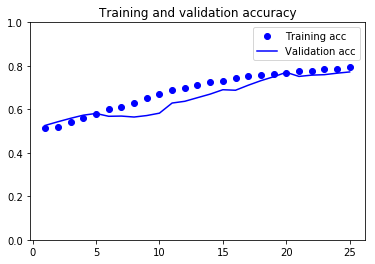

<Figure size 432x288 with 0 Axes>

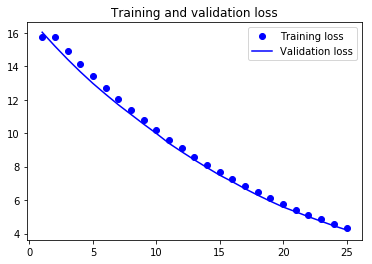

In [39]:
import matplotlib.pyplot as plt

history.history["loss"][0] =history.history["loss"][1] 
acc = history.history["acc"] # Training accuracy
val_acc = history.history["val_acc"] # Validation accuracy
loss = history.history["loss"] # Training loss
val_loss = history.history["val_loss"] # Validation loss

epochs = range(1, len(acc) + 1) #plots every epoch, here 10

plt.plot(epochs, acc, "bo", label = "Training acc") # "bo" gives dot plot
plt.plot(epochs, val_acc, "b", label = "Validation acc") # "b" gives line plot
plt.title("Training and validation accuracy")
plt.ylim((0,1))
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [32]:
prediction = model.predict(X_test)
y_pred = (prediction > 0.5).astype(int).reshape(-1,)


[0 0 0 0 0 0 0 0 0 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(50000,)
(50000,)
accuracy :0.52534


In [43]:
#print(y_pred[-200:])
y_test = np.array(y_test)
#print(y_test[-200:])
#print(y_test.shape)
#print(y_pred.shape)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix
print('accuracy :{0}'.format(accuracy_score(y_pred, y_test)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(50000,)
(50000,)
accuracy :0.52534


In [ ]:
#################################################################
#Save train history as dict 
#################################################################

with open(r"/usr4/cs542sp/zzjiang/History/Yoon_kim_original", "wb") as output_file:
    pickle.dump(history.history, output_file)


